In [35]:
# Install the packages if necessary
#install.packages("devtools")
#install.packages("bgsmtr")
#install.packages("corrplot")
#install.packages("pheatmap")
library(devtools)
library(glmnet)
library(corrplot)
library(pheatmap)
library(tidyverse)
#install_github("monogenea/gflasso")
#install.packages('glmnet')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ stringr 1.4.0
✔ tidyr   1.0.3     ✔ forcats 0.5.0
✔ readr   1.3.1     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()



As you probably have noticed, IDs 3, 4, 69 and 87 do not have any data from visit 3. These participants were excluded from analyses at visit 3 because they did not complete the fully controlled diet intervention period. 

In the PlosOne paper (where only group 1 and 3 were analyzed), 2 additional participants that were found to be outliers were excluded. Stine and I were wondering if, based on your analyses, you find any participants that are outliers and therefore should be excluded? 

In [2]:
dat = read.table('data_total.csv',dec=',',sep=';',header=T)

In [3]:
names(dat)

[1] "id"                                        
  [2] "visit"                                     
  [3] "group"                                     
  [4] "compliance"                                
  [5] "sex"                                       
  [6] "age"                                       
  [7] "BMI"                                       
  [8] "n3index"                                   
  [9] "total_cholesterol"                         
 [10] "ldl_cholesterol"                           
 [11] "hdl_cholesterol"                           
 [12] "TG"                                        
 [13] "glucose"                                   
 [14] "EPA"                                       
 [15] "DPA"                                       
 [16] "DHA"                                       
 [17] "Cer.d18.1.16.0._1"                         
 [18] "Cer.d18.1.22.6._2"                         
 [19] "Cer.d18.1.24.0._3"                         
 [20] "LysoPC.14.0._4"                            
 [21] "LysoPC.16.0._5"                            
 [22] "LysoPC.16.1._6"                            
 [23] "LysoPC.18.0._7"                            
 [24] "LysoPC.18.1._8"                            
 [25] "LysoPC.18.2._9"                            
 [26] "LysoPC.18.4e._10"                          
 [27] "LysoPC.20.3._11"                           
 [28] "LysoPC.20.4._12"                           
 [29] "LysoPC.20.5._13"                           
 [30] "LysoPC.22.5._14"                           
 [31] "LysoPC.22.6._15"                           
 [32] "LysoPE.18.0._16"                           
 [33] "LysoPE.18.2._17"                           
 [34] "LysoPE.20.1._18"                           
 [35] "LysoPE.20.3._19"                           
 [36] "PA.34.0._20"                               
 [37] "PA.34.0._21"                               
 [38] "PA.34.0._22"                               
 [39] "PA.34.0e._23"                              
 [40] "PA.38.5e._24"                              
 [41] "PA.38.6e._25"                              
 [42] "PC.30.0e._26"                              
 [43] "PC.30.3._27"                               
 [44] "PC.31.1..PE.34.1._28"                      
 [45] "PC.32.0._29"                               
 [46] "PC.32.1._30"                               
 [47] "PC.32.2._31"                               
 [48] "PC.32.5._32"                               
 [49] "PC.33.0._33"                               
 [50] "PC.33.1..PE.36.1._34"                      
 [51] "PC.33.2..PE.36.2._35"                      
 [52] "PC.33.2..PE.36.2._36"                      
 [53] "PC.34.0e._37"                              
 [54] "PC.34.1._38"                               
 [55] "PC.34.1e..PE.37.1e._39"                    
 [56] "PC.34.1e..PE.37.1e._40"                    
 [57] "PC.34.2._41"                               
 [58] "PC.34.3._42"                               
 [59] "PC.34.3e..PE.37.3e._43"                    
 [60] "PC.34.4e._44"                              
 [61] "PC.35.2._45"                               
 [62] "PC.36.0._46"                               
 [63] "PC.36.1._47"                               
 [64] "PC.36.2._48"                               
 [65] "PC.36.3._49"                               
 [66] "PC.36.4._50"                               
 [67] "PC.36.4._51"                               
 [68] "PC.36.4e._52"                              
 [69] "PC.36.5._53"                               
 [70] "PC.36.5._54"                               
 [71] "PC.36.5e..PE.38.5e._55"                    
 [72] "PC.37.4..PE.40.4._56"                      
 [73] "PC.38.1._57"                               
 [74] "PC.38.1e._58"                              
 [75] "PC.38.2._59"                               
 [76] "PC.38.3._60"                               
 [77] "PC.38.3e._61"                              
 [78] "PC.38.4._62"                               
 [79] "PC.38.4._63"     

In [5]:
table(dat$visit)


 2  3  4 
54 54 54 

In [87]:
#subset data to include visit2 and 3 only
dat %>% filter(visit!=4) -> dat_sub
#remove IDs 3, 4, 69 and 87 for non-compliant reason
dat_sub %>% filter(!(id %in% c(3, 4, 58, 69, 87))) -> dat_sub
dat_sub$visit <- dat_sub$visit %>% type.convert()
dat_sub$group <- dat_sub$group %>% type.convert()
dat_sub$sex <- dat_sub$sex %>% type.convert()

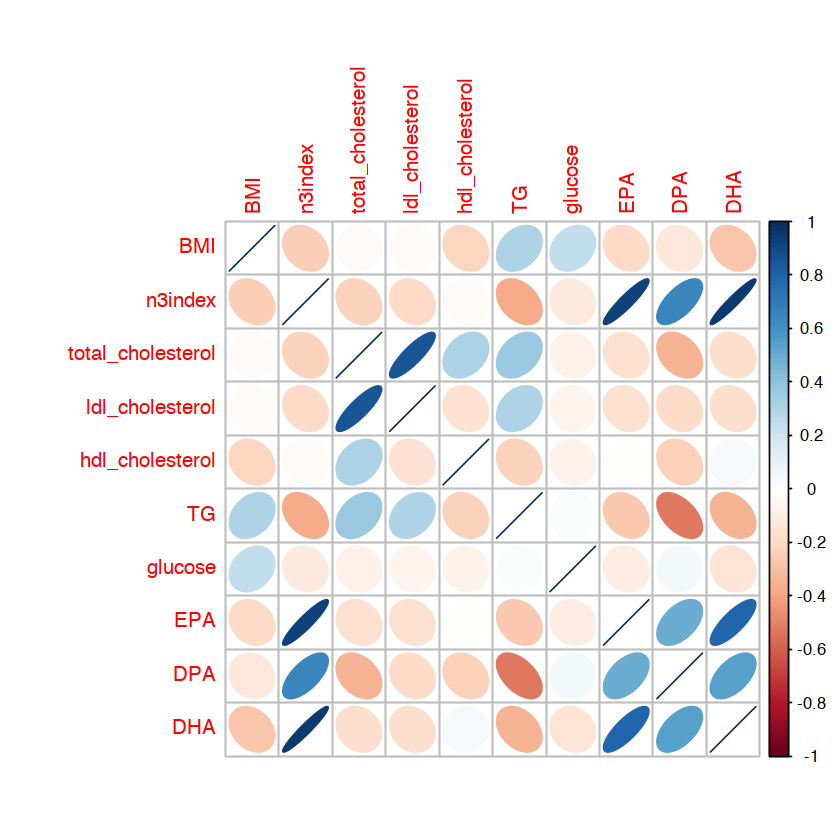

In [88]:
z = as.matrix(dat_sub[,7:16])
corrplot(cor(z,use='pairwise.complete.obs'),method='ellipse')

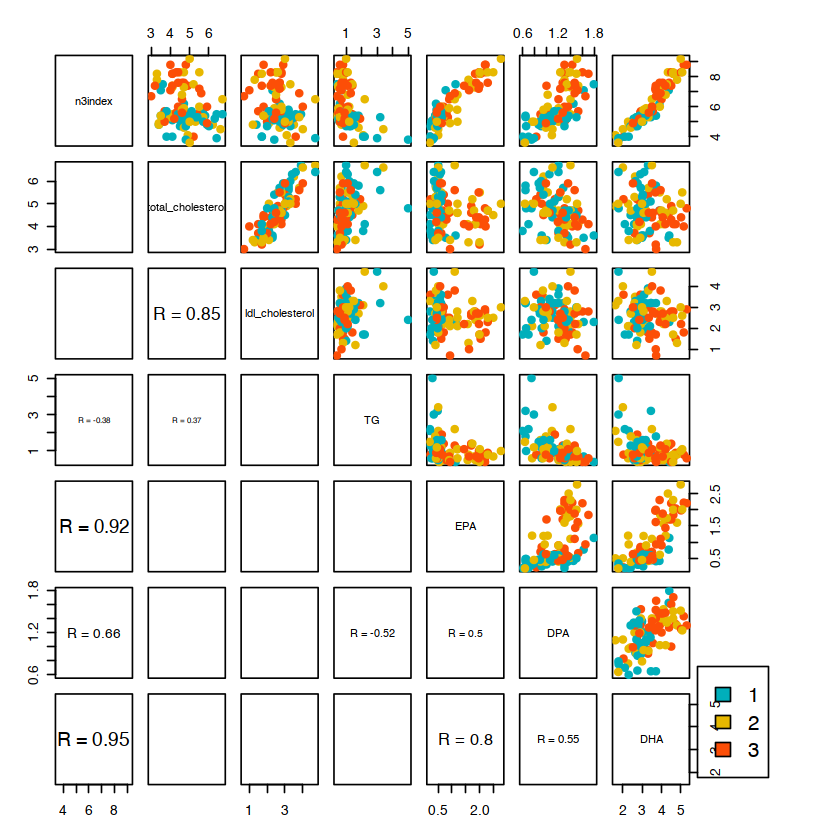

In [89]:
# visual inspection of the observation by group
my_cols <- c("#00AFBB", "#E7B800", "#FC4E07")
panel.cor <- function(x, y){
    usr <- par("usr"); on.exit(par(usr))
    par(usr = c(0, 1, 0, 1))
    r <- round(cor(x, y), digits=2)
    txt <- paste0("R = ", r)
    cex.cor <- 1.5
    text(0.5, 0.5, txt, cex = abs(cex.cor * r))
}
# Customize upper panel
upper.panel<-function(x, y){
  points(x,y, pch = 19, col = my_cols[as.factor(dat_sub$group)])
}
# Create the plots
pairs(~n3index + total_cholesterol + ldl_cholesterol + TG + EPA + DPA + DHA, 
        dat_sub ,lower.panel = panel.cor,
        upper.panel = upper.panel, oma=c(3,3,3,9))
par(xpd=TRUE)
legend("bottomright", legend = as.vector(unique(dat_sub$group)),  
    fill=my_cols)


In [100]:
# Run lasso with each clinical parameter as y, and consider one-way interactions between visits and all metabolomes
dat_sub %>% 
    select(-id,-visit,-group,-compliance,-sex,-age,-BMI,-n3index,-total_cholesterol,
           -ldl_cholesterol,-hdl_cholesterol,-TG,-glucose,-EPA,-DPA,-DHA) -> dat_meta
dat_sub %>% 
    select(-compliance, -n3index, -ldl_cholesterol, -hdl_cholesterol, -TG, -glucose, -EPA, -DPA, -DHA) -> dat1

f <- as.formula(y ~ dat1$visit*. + 0)
y <- dat_sub$total_cholesterol
# Second step: using model.matrix to take advantage of f
x <- model.matrix(f, dat_meta)

In [101]:
x[1:2,1:10]
dat_meta[1:2,1:10]

,dat1$visit,Cer.d18.1.16.0._1,Cer.d18.1.22.6._2,Cer.d18.1.24.0._3,LysoPC.14.0._4,LysoPC.16.0._5,LysoPC.16.1._6,LysoPC.18.0._7,LysoPC.18.1._8,LysoPC.18.2._9
1,2,0.3958064,10.87555,0.9689347,0.5945421,58.52954,0.9998873,17.48408,19.52595,45.65624
2,3,0.3639510,13.14921,1.3778300,0.3209105,49.32938,0.9776595,13.38883,14.57294,22.92978


,Cer.d18.1.16.0._1,Cer.d18.1.22.6._2,Cer.d18.1.24.0._3,LysoPC.14.0._4,LysoPC.16.0._5,LysoPC.16.1._6,LysoPC.18.0._7,LysoPC.18.1._8,LysoPC.18.2._9,LysoPC.18.4e._10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.3958064,10.87555,0.9689347,0.5945421,58.52954,0.9998873,17.48408,19.52595,45.65624,1.3523701
2,0.3639510,13.14921,1.3778300,0.3209105,49.32938,0.9776595,13.38883,14.57294,22.92978,0.8570832


In [72]:
x[1,567:569]

unknown_567                         unknown_568 
                         0.21830708                          0.08528136 
Cer.d18.1.16.0._1:Cer.d18.1.22.6._2 
                         4.30461033

In [79]:
table(dat_sub$visit)


 2  3  4 
49 49  0 

In [83]:
?type.convert